# Parse elapsed times from GitHub Actions logs

In [1]:
from utz import *
import plotly.express as px

In [2]:
runs = {
    4969272579: 'mamba',  # initial workflow, mamba CLI and conda-libmamba-solver only (5 jobs x 4 attempts)
    4969923328: 'conda',  # conda only (5 jobs x 4 attempts)
    4970360885: 'both',   # additional runs of all 3 builds (conda, conda-libmamba-solver, mamba; 5 jobs x 4 attempts each)
    #4972844135: 'both (ubuntu)'  # another round of both, switched to ubuntu:20.04 instead of nvidia/cuda:11.6.1-base-ubuntu20.04 (doesn't seem to make a difference)
    4972941899: 'conda (install solver without conda-forge)'  # avoid nondeterministic `conda-libmamba-solver` installation failures (caused by including `-c conda-forge`) that were present in the above runs
}

### Local cache for logs and run info downloaded via the `gh` CLI

In [3]:
CACHE = '.cache'
if not exists(CACHE):
    os.makedirs(CACHE)

### Parse `elapsed` time (output by `time docker build …`) for all steps in a given job

In [4]:
def rm_ansi(line):
    ansi_escape =re.compile(r'(\x9B|\x1B\[)[0-?]*[ -\/]*[@-~]')
    return ansi_escape.sub('', line)

def get_elapsed_times(job_id):
    path = f'{CACHE}/job-{job_id}.txt'
    if not exists(path):
        cmd = [ 'gh', 'run', 'view', '--job', f'{job_id}', '--log' ]
        with open(path, 'w') as f:
            subprocess.run(cmd, stdout=f)

    setup = None
    updates = []
    with open(path, 'r') as f:
        for line in f.readlines():
            m = search(r'(?P<elapsed>\S+)elapsed', rm_ansi(line))
            if m:
                elapsed = m['elapsed']
                if setup:
                    updates.append(elapsed)
                else:
                    setup = elapsed
    return dict(setup=setup, updates=updates)

### Parse elapsed times for all jobs in a given workflow run

In [5]:
def get_run_times(run_id, run_name, recompute=False):
    run_path = f'{CACHE}/run-{run_id}.parquet'
    if recompute or not exists(run_path):
        jobs = (
            DF(process.json('gh', 'run', 'view', run_id, '--json', 'jobs'))
            .jobs
            .apply(Series)
            .rename(columns={ 'databaseId': 'job_id' })
            .set_index('job_id')
        )
        jobs = sxs(
            jobs,
            jobs.name.str.extract(r'(?P<build>mamba-(?:cli|solver)|conda|conda-libmamba-solver|mamba).*(?P<job>\d+)'),
            jobs.url.str.extract(r'^.*/(?P<url_id>\d+)$').url_id,
        )
        jobs['run_id'] = run_id
        jobs['run_name'] = run_name

        job_times = sxs(
            DF([
                dict(job_id=job_id, **get_elapsed_times(job_id))
                for job_id in jobs.index
            ])
            .set_index('job_id'),
            jobs[['url_id', 'run_id', 'conclusion', 'build', 'job']],
        )

        step_times = job_times.updates.apply(Series)
        step_times = (
            step_times
            .reset_index()
            .melt(
                'job_id',
                step_times.columns.tolist(),
                var_name='attempt',
                value_name='elapsed_str',
            )
            .sort_values(['job_id', 'attempt'])
            .set_index('job_id')
            .dropna()
        )

        merged = step_times.merge(jobs[['build', 'run_name', 'conclusion']], on='job_id')
        p = merged.elapsed_str.str.extract(r'^(?P<m>\d+):(?P<s>\d+)\.(?P<cs>\d+)$').applymap(int)
        elapsed = p.m * 60 + p.s + p.cs / 100
        merged['elapsed'] = elapsed

        merged.loc[merged.build == 'mamba-solver', 'build'] = 'conda-libmamba-solver'
        merged.loc[merged.build == 'mamba-cli', 'build'] = 'mamba'
        fail_mask = merged.conclusion == 'failure'
        assert (merged[fail_mask].build == 'conda-libmamba-solver').all()
        merged['label'] = merged['build']
        merged.loc[fail_mask, 'label'] = 'conda-libmamba-solver (failed)'

        merged.to_parquet(run_path)
    return read_parquet(run_path)

### Combine elapsed times for all workflow runs listed in `runs` above

In [6]:
all_attempts = pd.concat([
    get_run_times(run_id, run_name)
    for run_id, run_name in runs.items()
])
all_attempts = pd.concat([
    all_attempts[all_attempts.build == build]
    for build in [ 'conda', 'conda-libmamba-solver', 'mamba' ]
])
all_attempts['elapsed_m'] = all_attempts.elapsed / 60
all_attempts

,attempt,elapsed_str,build,run_name,conclusion,elapsed,label,elapsed_m
job_id,,,,,,,,
13460568257,0,11:18.20,conda,conda,success,678.20,conda,11.303333
13460568257,1,11:20.34,conda,conda,success,680.34,conda,11.339000
13460568257,2,11:25.72,conda,conda,success,685.72,conda,11.428667
13460568257,3,11:04.96,conda,conda,success,664.96,conda,11.082667
13460568304,0,14:50.64,conda,conda,success,890.64,conda,14.844000
...,...,...,...,...,...,...,...,...
13461384332,3,1:57.93,mamba,both,success,117.93,mamba,1.965500
13461384383,0,2:26.84,mamba,both,success,146.84,mamba,2.447333
13461384383,1,2:26.55,mamba,both,success,146.55,mamba,2.442500


### Plot elapsed time for each build type

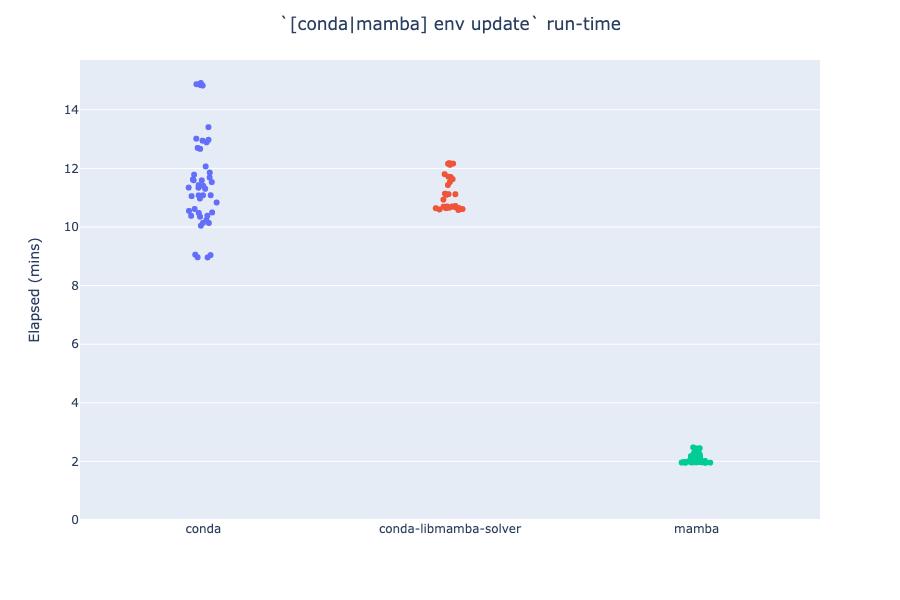

In [7]:
fig = px.strip(
    all_attempts[all_attempts.conclusion == 'success'],
    x='build',
    y='elapsed_m',
    color='build',
    labels={ 'build': '', 'elapsed_m': 'Elapsed (mins)', 'run_name': 'environment.yml deps' },
).update_layout(
    title=dict(
        text='`[conda|mamba] env update` run-time',
        x=0.5,
    ),
    yaxis=dict(
        tickformat='%M',
    ),
    showlegend=False,
).update_yaxes(
    rangemode='tozero',
)
png_path = 'run-times.png'
fig.write_image(png_path, width=900, height=600)

from IPython.display import Image, display
display(Image(filename=png_path))
#fig.show()